In [1]:
%matplotlib inline

We start by initializing the Earth Engine API.

In [2]:
import ee
ee.Initialize()

Then we import in other Python packages we need.

In [3]:
import datetime
from matplotlib import dates
import matplotlib.dates as mdates
from pylab import *

Next we define the Landsat bands that we would like to plot, along with the starting and ending times.

In [4]:
xBand = 'time'
yBandList = ['B1',
        u'B2',
        u'B3',
        u'B4',
        u'B5',
#         u'B6_VCID_1',
#         u'B6_VCID_2',
        u'B6',     
        u'B7',
        u'B8',
        u'B9',
        u'B10',
        u'B11',
        u'BQA'
    ]
startTime = datetime.datetime(2013, 4, 7)
endTime = datetime.datetime(2017, 4, 7)

Next we contruct a filtered ImageCollection for the date range, and extract band information for a specified point location.

In [5]:
collection = ee.ImageCollection('LANDSAT/LC8_L1T_TOA').filterDate(startTime, endTime)
# point = {'type':'Point', 'coordinates':[ -116.88629,36.56122]};  # death valley (should be stable)
point = {'type':'Point', 'coordinates':[ 37.4, 0.2]};  # Lewa (should be stable)
info = collection.getRegion(point,500).getInfo()

We separate the information returned into column headers and data.

In [6]:
# extract the header column names
header = info[0]
# create a Numpy array of the data
data = array(info[1:])

Next we extract time information and convert it to at Python datatime data type.

In [7]:
# extract the time information
iTime = header.index('time')
# print(iTime)
# convert to Python datetime objects
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

Extract the data columns what we want to display on the plot.

In [8]:
iBands = [header.index(b) for b in yBandList]
yData = data[0:,iBands].astype(np.float)
# print ("iBands: ", iBands)
print yData[:2]

[[  1.40439242e-01   1.25889838e-01   1.18831448e-01   1.09541692e-01
    2.47840643e-01   2.11774543e-01   1.32811621e-01   1.13298580e-01
    2.77326461e-02   2.87641785e+02   2.81555481e+02   2.86720000e+04]
 [  1.06570683e-01   9.21621993e-02   8.87259617e-02   8.06922764e-02
    2.47669622e-01   1.97500587e-01   1.10694170e-01   8.38204399e-02
    1.13750761e-03   3.02041199e+02   3.00141113e+02   2.04800000e+04]]


Calculate NDVI

In [9]:
def NDVI(image):
    """A function to compute NDVI."""
    return image.expression('float(b("B5") - b("B4")) / (b("B5") + b("B4"))')

In [10]:
# band3 = yData[:,2] # landsat7
band4 = yData[:,3] # Red band
band5 = yData[:,4] # NIR band
ndvi = (band5 - band4) / (band5 + band4)
# ndvi = (band4 - band3) / (band4 + band3) # landsat7

And finally, we create a plot of Landsat band values as a function of time.

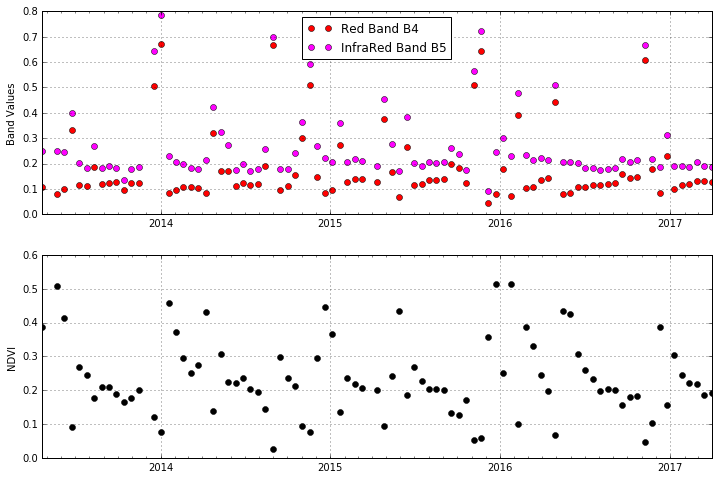

In [11]:
# matplotlib date format object

fig = figure(figsize=(12,8), dpi=80)

# plot the band values
ax1 = fig.add_subplot(211)
ax1.plot(time, yData[:,3], 'o', color="red", label="Red Band B4")
ax1.plot(time, yData[:,4], 'o', color="magenta",  label="InfraRed Band B5")
ax1.legend(loc='best')
ax1.grid(True)

#plt.title('Band values as a function of time')
ax1.set_ylabel('Band Values')

# plot NDVI
ax2 = fig.add_subplot(212, sharex=ax1)
ax2.plot(time, ndvi, 'o', color="black", label="NDVI")
ax2.grid(True)
start, end = ax2.get_xlim()
ax2.xaxis.set_ticks(np.arange(start, end, 64.5))

# Format the ticks.
years    = mdates.YearLocator()   # every year
months   = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax2.set_ylabel('NDVI')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)

In [12]:
# Convert the timestamp to a numpy array
t = np.array([i.toordinal() for i in time])
t

array([734979, 735011, 735027, 735043, 735059, 735075, 735091, 735107,
       735123, 735139, 735155, 735171, 735187, 735219, 735235, 735251,
       735267, 735283, 735299, 735315, 735331, 735347, 735363, 735379,
       735395, 735411, 735427, 735443, 735459, 735475, 735491, 735507,
       735523, 735539, 735555, 735571, 735587, 735603, 735619, 735635,
       735651, 735667, 735699, 735715, 735731, 735747, 735763, 735779,
       735795, 735811, 735827, 735843, 735859, 735875, 735891, 735907,
       735923, 735939, 735955, 735971, 735987, 736003, 736019, 736035,
       736051, 736067, 736083, 736099, 736115, 736131, 736147, 736163,
       736179, 736195, 736211, 736227, 736243, 736259, 736275, 736291,
       736307, 736323, 736339, 736355, 736371, 736387, 736403, 736419])

$$
\begin{bmatrix}
t_1 & 1 \\\
t_2 & 1 \\\
\vdots & \vdots \\\
t_n & 1
\end{bmatrix}
\begin{bmatrix}
x_0 \\\
x_1 
\end{bmatrix}=
\begin{bmatrix}
y_1 \\\
y_2 \\\
\vdots \\\
y_n
\end{bmatrix}
$$

$$ \mathbf{A}\mathbf{x} = \mathbf{b} $$

$$ \mathbf{x} = \mathbf{A} \backslash \mathbf{b} $$

In [13]:
A = array([ t, ones(len(t))]).transpose()
b = ndvi
x = linalg.lstsq(A,b)[0] # obtaining the parameters
x

array([ -2.15985601e-05,   1.61247178e+01])

In [14]:
b_hat = A.dot(x)

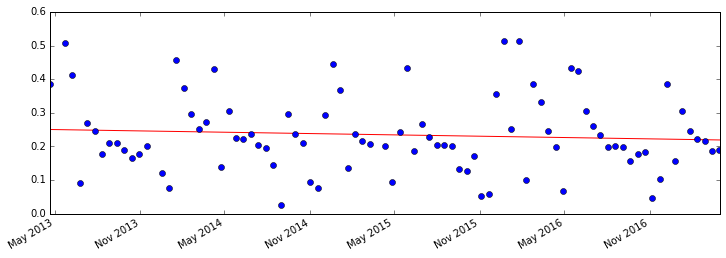

In [15]:
fig2 = figure(figsize=(12,4), dpi=80)
plot(time,b_hat.transpose(),'r-',t,b,'o')
fig2.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
fig2.autofmt_xdate()